In [1]:
# Import relevant libraries
import os
import pandas as pd

from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters, TEMPLATE_TIME_SETUP_DICT

import numpy as np

from SALib.sample import saltelli

from comparative_gsa.sample_input_space import sample_input_space

import json

from ModularCirc import BatchRunner

from comparative_gsa.simulate_data import simulate_data
from comparative_gsa.calculate_output_features import calculate_output_features

from SALib.analyze.sobol import analyze

In [ ]:
param_path = '../inputs/parameters_naghavi_constrained_fixed_T_v_tot_v_ref.json'
# Get the filename from the path, without extension
param_filename = os.path.splitext(os.path.basename(param_path))[0]

n_samples = 544

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'


In [3]:
# Load input_544_samples.csv
input_csv = os.path.join(simulation_out_path, "input_samples_544.csv")
X = pd.read_csv(input_csv)
print("Loaded input samples:", X.shape)

# Load simulation_summary.csv
summary_csv = os.path.join(simulation_out_path, "simulations_summary.csv")
Y = pd.read_csv(summary_csv)
print("Loaded simulation summary:", Y.shape)

Loaded input samples: (544, 35)
Loaded simulation summary: (544, 32)


In [4]:
output_feature = "v_ao_mean"  # Change to any column name in Y
Y_feature = Y[output_feature].values  # .values converts to numpy array.
Y_feature.shape

(544,)

In [5]:
relevant_columns = ['ao.r',
 'ao.c',
 'art.r',
 'art.c',
 'ven.r',
 'ven.c',
 'av.r',
 'mv.r',
 'la.E_pas',
 'la.E_act',
 'la.v_ref',
 'la.k_pas',
 'lv.E_pas',
 'lv.E_act',
 'lv.v_ref',
 'lv.k_pas']

problem = {
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : X[relevant_columns].describe().loc[['min', 'max']].T.values
}

In [6]:
# Do the sobol_analyse for GSA
sobol_indices = analyze(problem, Y_feature, calc_second_order=True)

16


/Users/lbokeria/projects/health_gc/cvd_net_project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [7]:
# S1, ST and ST cumulative sum is being calculated and the results are saved to file.
# Create results directory
results_dir = os.path.join(simulation_out_path, 'sensitivity_results')
os.makedirs(results_dir, exist_ok=True)

# Save S1 results
S1 = pd.DataFrame(sobol_indices['S1'], index=problem['names'], columns=['S1'])
S1.sort_values('S1', inplace=True, ascending=False)
S1.to_csv(os.path.join(results_dir, f's1_{n_samples}.csv'))

# Save ST results  
ST = pd.DataFrame(sobol_indices['ST'], index=problem['names'], columns=['ST'])
ST.sort_values('ST', inplace=True, ascending=False)
ST.to_csv(os.path.join(results_dir, f'st_{n_samples}.csv'))

# Save ST cumulative sum
ST_cumsum = ST.cumsum() / ST.cumsum().iloc[-1]
ST_cumsum.to_csv(os.path.join(results_dir, f'st_cumsum_{n_samples}.csv'))

# Save S2 results (second-order interactions)
S2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'], columns=problem['names'])
S2.to_csv(os.path.join(results_dir, f's2_{n_samples}.csv'))

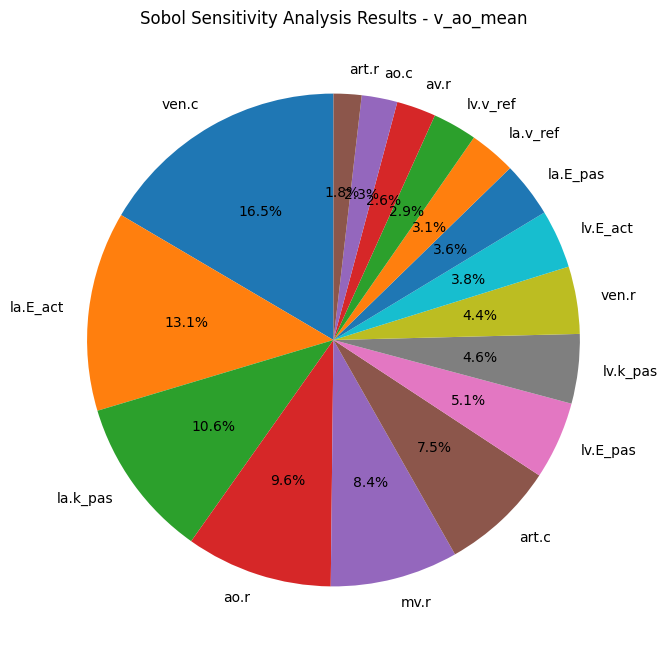

Top 3 most sensitive parameters:
  1. ven.c: 7.363
  2. la.E_act: 5.833
  3. la.k_pas: 4.706


In [8]:
import matplotlib.pyplot as plt

# Use the already sorted ST DataFrame
labels = ST.index
sizes = ST['ST']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f'Sobol Sensitivity Analysis Results - {output_feature}')
plt.show()

# Print summary
print(f"Top 3 most sensitive parameters:")
for i in range(min(3, len(ST))):
    print(f"  {i+1}. {ST.index[i]}: {ST['ST'].iloc[i]:.3f}")

In [9]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from autoemulate.core.sensitivity_analysis import _sobol_results_to_df 

In [10]:
results = {
    output_feature: sobol_indices
}

In [19]:
rename_dict = {
    "variable": "index",
    "S1": "value",
    "S1_conf": "confidence",
    "ST": "value",
    "ST_conf": "confidence",
    "S2": "value",
    "S2_conf": "confidence",
}
rows = []
for output, result in results.items():
    s1, st, s2 = result.to_df()
    s1 = (
        s1.reset_index()
        .rename(columns={"index": "parameter"})
        .rename(columns=rename_dict)
    )
    s1["index"] = "S1"
    st = (
        st.reset_index()
        .rename(columns={"index": "parameter"})
        .rename(columns=rename_dict)
    )
    st["index"] = "ST"
    s2 = (
        s2.reset_index()
        .rename(columns={"index": "parameter"})
        .rename(columns=rename_dict)
    )
    s2["index"] = "S2"

    df = pd.concat([s1, st, s2])
    df["output"] = output
    rows.append(df[["output", "parameter", "index", "value", "confidence"]])

sobol_df = pd.concat(rows)

/Users/lbokeria/projects/health_gc/cvd_net_project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


S1 [-0.14256091 -0.17043874  0.49585416 -1.1659183   0.38804852  0.50332891
 -0.60144307 -0.84755514  0.16614979 -0.0852096  -0.10553082 -1.38505493
  1.4331291  -1.53370117  0.63029871 -1.11826027]
S1_conf [1.60558452 1.01887401 0.68829022 1.89024351 1.11228423 1.90651247
 0.73136386 1.46402438 0.99899537 2.20195495 1.31870727 1.81690362
 1.09744602 1.38334558 0.99270006 2.11825297]
ST [4.28393983 1.04243287 0.81604406 3.35232063 1.96802741 7.36287853
 1.14796541 3.7336997  1.61677555 5.83348928 1.36235636 4.70581277
 2.2712912  1.71000987 1.29275554 2.0282949 ]
ST_conf [3.06883179 0.73580186 0.68055285 4.1616167  1.22478214 6.10892432
 0.7887882  3.32880951 1.29809757 3.1005658  1.04371306 5.80401606
 1.32445015 1.37276681 0.65215729 3.0306555 ]
S2 [[            nan -4.26143286e-01 -7.16777274e-02 -4.47360078e-02
   2.05179486e-01  1.34429474e+00 -5.91884333e-01  4.42495086e-01
  -3.88477812e-01  1.71134999e+00 -8.11334083e-01  8.25426800e-01
   2.03005318e-01  2.38223781e-01 -5.5331

In [14]:
ST

,ST
ven.c,7.362879
la.E_act,5.833489
la.k_pas,4.705813
ao.r,4.283940
mv.r,3.733700
art.c,3.352321
lv.E_pas,2.271291
lv.k_pas,2.028295
ven.r,1.968027
lv.E_act,1.710010


In [15]:
s1

,parameter,value,confidence,index
0,ao.r,4.283940,3.068832,S1
1,ao.c,1.042433,0.735802,S1
2,art.r,0.816044,0.680553,S1
3,art.c,3.352321,4.161617,S1
4,ven.r,1.968027,1.224782,S1
5,ven.c,7.362879,6.108924,S1
6,av.r,1.147965,0.788788,S1
7,mv.r,3.733700,3.328810,S1
8,la.E_pas,1.616776,1.298098,S1
9,la.E_act,5.833489,3.100566,S1


In [16]:
sobol_df = _sobol_results_to_df(results)

/Users/lbokeria/projects/health_gc/cvd_net_project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


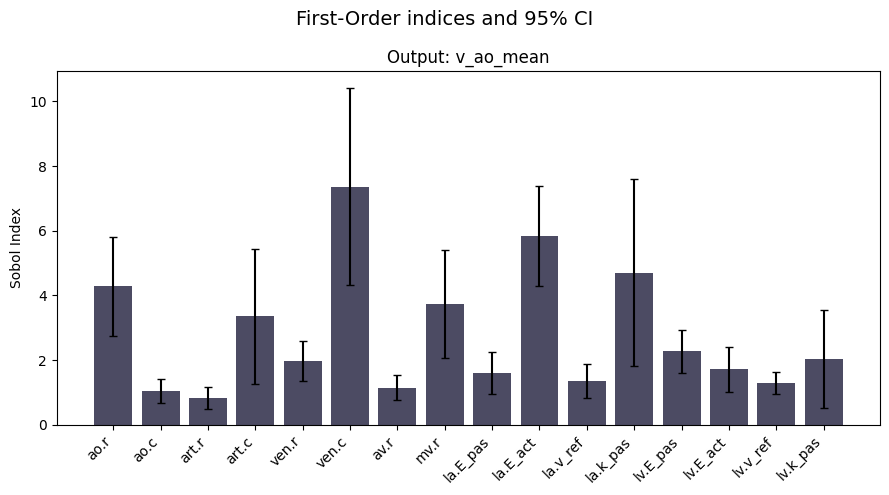

In [17]:
figsize = (9, 5)

SensitivityAnalysis.plot_sobol(sobol_df, index="S1", figsize=figsize) 